<a href="https://colab.research.google.com/github/Cseudave/automatic_tops/blob/main/05_Obtener_videos_con_API_Youtube.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Crear los videos cortos

MoviePy es una excelente librería que permite trabajar con videos usando python. Aunque no está optimizada para utilizar tarjetas gráficas, será muy útil.  

## Instalar librerías necesarias

In [ ]:
# Instalamos librerías
!pip install google-api-python-client
!pip install pytube

!pip install moviepy
!pip install imageio-ffmpeg 
!pip install imageio
!apt install imagemagick

!pip install IPython
!pip install mpld3 

!pip install fuzzywuzzy

!pip install playsound

In [ ]:
# Actulizamos librerías
!pip install --upgrade imageio-ffmpeg
!pip install --upgrade moviepy 
!pip install --upgrade imageio
!pip install --upgrade ffmpeg

In [ ]:
# Configuración adicional para trabajar con texto en movipy usando ImageMagick
!cat /etc/ImageMagick-6/policy.xml | sed 's/none/read,write/g'> /etc/ImageMagick-6/policy.xml

In [ ]:
# Importamos librerías
from apiclient.discovery import build
from pytube import YouTube
import os 
import time
from bs4 import BeautifulSoup

import re
import numpy as np
from numpy import arange
import pandas as pd
import matplotlib.pyplot as plt

import csv

from IPython.core.display import HTML
import mpld3 
from scipy.stats import moment
from moviepy.editor import *

import os 

from moviepy.audio.AudioClip import concatenate_audioclips
from moviepy.editor import concatenate_videoclips
from moviepy.editor import VideoFileClip
from moviepy.editor import ColorClip
from moviepy.editor import CompositeVideoClip
from moviepy.editor import *

from IPython.display import Audio
from datetime import datetime

## Obtener el opening

In [ ]:
# Obtenemos mi clave de la API de Youtube
def get_api():
  youtube = build('youtube','v3',developerKey = 'Agregar clave')
  return youtube

In [ ]:
# Descargar video desde youtube
def download_op(opening, youtube, directorio = 'ops_full/'):
  filenames = os.listdir(str(directorio))
  if str(opening) + '.mp4' in filenames:
    print('Descargado')
    url = ''
  else:
    print('Descargando')
    # Crea una instancia de YouTube con la URL del video que quieres descargar
    url = best_op(opening, youtube=youtube)
    print(str(opening))
    # Descargar el video de Youtube
    video = YouTube(str(url))
    # Obtén el primer stream de video disponible
    descarga = video.streams.get_highest_resolution()
    # Descarga el video en el directorio actual
    descarga.download(output_path=str(directorio), filename=str(opening) + '.mp4')
    print('Descargado')
    # Se intenta descargar el mapa de most-replayed del video
    try:
      map_op(url, opening)
    except:
      print('Falla selenium')
  return url, opening

Para encontrar el mejor corte para la edición será útil usar la información de las partes más reproducidas en los videos de youtube, si es el caso 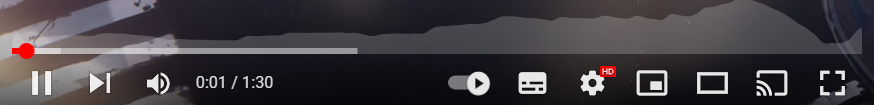

In [ ]:
def map_op(url, opening='', directorio='ops_maps/'):
  #Se usa Selenium para obtener el los datos de las partes más reproducidas
    filenames = os.listdir(str(directorio))
    if str(opening) + '.csv' in filenames:
      print('Obtenido')
    else:
      print('Obteniendo')

      options = Options()
      options.add_argument("--headless")
      options.add_argument("--no-sandbox")

      options.headless = True

      driver = webdriver.Chrome("/usr/bin/chromedriver", options=options)
      
      driver.get(url)
      driver.maximize_window()
      time.sleep(8)
      soup = BeautifulSoup(driver.page_source,"html.parser")
      try:
        mydivs = soup.find("path", {"class": "ytp-heat-map-path"}).get('d')
        #print(mydivs)
        nice_map = mydivs.split('C')
        result = [re.sub(r'\d{1,3}\.0,', '', item) for item in nice_map]
        for element in result:
          element.split(' ')
        #print(result)
        head_map = []
        for element in result:
          head_map.append(element.split(" "))
        head_map = sum(head_map, [])
        result = list(filter(lambda x: x != '', head_map))

        result.pop(0)
        result.pop(-1)

        result = [float(x) for x in result]
        result = [1-float(x)/max(result) for x in result]

        df = pd.DataFrame(result)
        df.to_csv(str(directorio) + 'map_' + str(opening) + '.csv')
        # Creamos una figura y un eje
        fig, ax = plt.subplots()
        fig.set_size_inches(10, 1)

        data = result
        x = arange(len(result))/3
        plt.plot(x, result)
        plt.show
      except:
        result = np.ones(300)
        df = pd.DataFrame(result)
        df.to_csv(str(directorio) + 'nmap_' + str(opening) + '.csv')
        print('No tiene mapa')

In [ ]:
# Se busca el mejor video según algunos criterios
def best_op(anime, youtube, limit=8):
  data = get_results(anime, youtube)
  keychannels = ['crun', 'mappa', 'kado']
  best = 0
  url = 0
  for element in data:
    seconds = element['duration']
    #print(3econds)
    if abs(seconds - 110) < 30:
      posible = int(element['views'])
      #print(posible)
      if posible > best:
        best = posible
        #print(best)
        title = element['title']
        url = element['url']
        for channel in keychannels: 
          if channel in (element['channel']).lower():
            return url 
  return url

In [ ]:
# Se hace la busqueda en youtube y se obtiene el listado de los posibles videos
def get_results(opening, youtube, limit=8):

  request = youtube.search().list(q='opening OP ' + str(opening), 
                                  part='snippet',
                                  type='video', 
                                  maxResults=limit)
  response = request.execute()
  list_data = []
  for item in response['items']:
    #print(f'Video: {item["snippet"]["title"]}')
    url = 'https://www.youtube.com/watch?v='+ str(item["id"]["videoId"])
    video_id = item["id"]["videoId"]
    # Extraemos informacion del video con id=id
    data = youtube.videos().list(part="snippet,contentDetails,statistics",id=video_id).execute()

    for element in data['items']:
      list_data.append({'title': element['snippet']['title'],
                'channel': element['snippet']['channelTitle'],
                'views': element['statistics']['viewCount'],
                'duration':parse_time(element['contentDetails']['duration']),
                'url':url
                })
  return list_data

In [ ]:
# Se formatea el tiempo del video de Youtube
def parse_time(duration):
  try:
    parsed_duration = re.search(f"PT(\d+H)?(\d+M)?(\d+S)", duration).groups()
  except:
    parsed_duration = ''
  duration_str = ""
  for d in parsed_duration:
      if d:
          duration_str += f"{d[:-1]}:"
  seconds = duration_str.strip(":")
  seconds = seconds.split(':')
  if len(seconds) == 2:
    seconds = int(seconds[0])*60 + int(seconds[1])
  else:
    seconds = 1000
  return seconds